# Libraries & Necessary functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import norm
from scipy.optimize import least_squares
from scipy.optimize import fsolve
from math import log, sqrt, exp
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Root Bracketer to ensure optimum guesses for brentq calculation
def rootBracketing(f, a, b, maxIter = 7000, factor = 0.7):
    for k in range(maxIter):
        if f(a) * f(b) < 0:
            return (a, b)
        if abs(f(a)) < abs(f(b)):
            a += factor * (a-b) # if f(a) is closer to 0, change a
        else:
            b += factor * (b-a) # if f(b) is closer to 0, change b
    return (a, b)

In [3]:
#Converts the Tenor provided in excel file to integer values
def tenor(df):
    int_tenor = []
    for i in df["Tenor"]:
        integer = int(i[ :-1])
        int_tenor.append(integer)
    int_tenor[0] = 0.5
    return int_tenor

In [4]:
#Extract & Clean excel file sheets.
def df_parser(name = 'IR Data.xlsx'):
    df = pd.read_excel(name, sheet_name = ["IRS","OIS","Swaption"])
    IRS = df["IRS"].dropna(thresh=len(df["IRS"]) - 2, axis=1)
    IRS['Tenor'] = tenor(IRS)
    OIS = df["OIS"].dropna(thresh=len(df["OIS"]) - 2, axis=1)
    OIS['Tenor'] = tenor(OIS)
    Swaption = df["Swaption"]
    Swaption.columns = df["Swaption"].iloc[1, : ]
    Swaption = df['Swaption'].iloc[2: ].reset_index(drop=True)
    return IRS,OIS,Swaption

In [5]:
IRS,OIS,Swaption = df_parser()

## Import the OIS, LIBOR & Forward Swap Rates from Part 1: Bootstrapping Swap Curves

In [6]:
Odisc = pd.read_pickle('Odisc')
Ldisc = pd.read_pickle('Ldisc')
FSR = pd.read_pickle('FSR')

## Setup necessary functions to perform DD & SABR calibration

In [7]:
def PV01(Odisc, t, T, freq = 2):
    expiry = int((t*freq))
    tenor = int((t+T)*freq)
    if t == 0:
        expiry = 1
        tenor = int(T*freq + 1)
    return (1/freq)*(Odisc['Discount'][expiry:tenor]).sum()

def fwd_swap(Ldisc, Odisc, t, T, freq = 2):
    expiry = int((t*freq))
    tenor = int((t+T)*freq)
    if t == 0:
        expiry = 1
        tenor = int(T*freq + 1)
    numerator = (1/freq)*(Odisc['Discount'][expiry:tenor]*Ldisc['Libor'][expiry:tenor]).sum()
    denominator = PV01(Odisc, t, T)
    return numerator/denominator

In [8]:
def impliedVolatility(F, K, disc, price, T, Type='Payer'):
    impliedVol = fsolve(lambda x: price - Black76(F, K, x, T, disc, Type = Type),0.5)
    return impliedVol[0]

def Black76(F, K, vol, T, disc, Type = 'Payer'):
    c1 = (np.log(F/K) + (vol**2)/2*T) / (vol*np.sqrt(T))
    c2 = c1 - vol*np.sqrt(T)
    if Type == 'Payer':
        return disc*(F*norm.cdf(c1) - K*norm.cdf(c2))
    elif Type == 'Receiver':
        return disc*(K*norm.cdf(-c2) - F*norm.cdf(-c1))
    
def DisplacedDiffusion(F, K, vol, T, disc, beta=1e-10, Type='Payer'):
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*vol)**2/2*T) / (beta*vol*np.sqrt(T))
    c2 = c1 - beta*vol*np.sqrt(T)
    if Type == 'Payer':
        return disc*((F/beta)*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))
    elif Type == 'Receiver':
        return disc*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

def ddcalibration(x, F, strikes, disc, vols, T, Type='Payer'):
    err = 0.0
    for i, vol in enumerate(vols):
        price = DisplacedDiffusion(F, strikes[i], x[1], T, disc, x[0], Type=Type)
        err += (vol - impliedVolatility(F, strikes[i], disc, price, T))**2
    return err

In [9]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*log(F/X)
        zhi = log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T, beta):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T, x[0], beta, x[1], x[2]))**2
    return err

## Setup a pre-processing DataFrame which consists of:
* Expiry, Tenor & Rate of Forward Swap Rates
* Market Observed Volatilities in Decimals
* PV01

In [10]:
market_data = Swaption.copy().drop(columns=['Expiry','Tenor'])
market_data = pd.concat([FSR,market_data],axis = 1)
market_data.iloc[:, 3:] = market_data.iloc[:, 3:] / 100
market_data

,Expiry,Tenor,FSR,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,0.032007,0.9157,0.6203,0.4413,0.31224,0.26182,0.225,0.2096,0.214,0.2434,0.27488,0.30297
1,1,2,0.033259,0.8327,0.6124,0.4657,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523
2,1,3,0.034011,0.7392,0.5687,0.4477,0.35745,0.32317,0.2978,0.2829,0.278,0.2877,0.30725,0.32833
3,1,5,0.035255,0.5519,0.4464,0.3651,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165
4,1,10,0.038428,0.4118,0.3504,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355
5,5,1,0.039274,0.678,0.4909,0.384,0.31485,0.2906,0.2726,0.2604,0.2532,0.2494,0.2532,0.2598
6,5,2,0.040075,0.5788,0.4641,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.2654,0.2676
7,5,3,0.040072,0.5343,0.4444,0.3818,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.262,0.2615
8,5,5,0.041093,0.4199,0.36524,0.32326,0.29005,0.27677,0.266,0.2573,0.2502,0.2406,0.2357,0.234
9,5,10,0.043634,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.2249,0.2225


## Setup another DataFrame to contain range of strikes for every Forward Rate Swaps

In [11]:
bps = [0 if i == 8 else int(market_data.columns[i][0:-3]) / 10000 for i in range(3, len(market_data.columns))]

In [12]:
strikes = pd.DataFrame(market_data.iloc[:,:3], index = market_data.index)
for i in range(len(market_data.columns[3:])):
    strikes.loc[:, market_data.columns[3 + i]] = market_data.iloc[:,2] + bps[i]

In [13]:
PVBP = []
for i in range(len(market_data)):
    t,T = market_data['Expiry'][i], market_data['Tenor'][i]
    PVBP.append(PV01(Ldisc,t,T))
market_data['PVBP'] = PVBP 
market_data

,Expiry,Tenor,FSR,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,PVBP
0,1,1,0.032007,0.9157,0.6203,0.4413,0.31224,0.26182,0.225,0.2096,0.214,0.2434,0.27488,0.30297,0.949778
1,1,2,0.033259,0.8327,0.6124,0.4657,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523,1.868184
2,1,3,0.034011,0.7392,0.5687,0.4477,0.35745,0.32317,0.2978,0.2829,0.278,0.2877,0.30725,0.32833,2.755040
3,1,5,0.035255,0.5519,0.4464,0.3651,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165,4.436227
4,1,10,0.038428,0.4118,0.3504,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355,8.092519
5,5,1,0.039274,0.678,0.4909,0.384,0.31485,0.2906,0.2726,0.2604,0.2532,0.2494,0.2532,0.2598,0.824699
6,5,2,0.040075,0.5788,0.4641,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.2654,0.2676,1.617012
7,5,3,0.040072,0.5343,0.4444,0.3818,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.262,0.2615,2.378352
8,5,5,0.041093,0.4199,0.36524,0.32326,0.29005,0.27677,0.266,0.2573,0.2502,0.2406,0.2357,0.234,3.809526
9,5,10,0.043634,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.2249,0.2225,6.883596


# 1. Displaced-Diffusion Model Calibration

In [14]:
data_DD = pd.DataFrame(market_data.iloc[:,:3], columns = market_data.columns, index = market_data.index)
data_DD['Beta'], data_DD['Sigma'] = np.NaN, np.NaN

In [15]:
def calibration(data, model_type = "SABR", empty_data = None): # input market_data for DD, Swaption for SABR
    if model_type == "DD":
        calibration_dictionary = {}
        lower_limit, upper_limit = data.columns[7:9], data.columns[8 :10][ : :-1]
        for lower,upper in zip(lower_limit, upper_limit):
            fill_data_DD = empty_data.copy()
            for i in range(len(data.index)):
                F, T, disc = data.loc[i, 'FSR'], data.loc[i, 'Expiry'], data.loc[i, 'PVBP']
                estimate = [0.05, 0.25]
                res = least_squares(lambda x: ddcalibration(x, F, strikes.loc[i, lower:upper], disc,
                                                            data.loc[i, lower:upper], T, Type='Payer'),
                                                            estimate, bounds = ((0, 0), (1, np.inf))
                                                            )
                beta_dd, sigma_dd = res.x[0], res.x[1]
                fill_data_DD.loc[i,'Beta'], fill_data_DD.loc[i,'Sigma'] = beta_dd, sigma_dd

                for j in range(3, 14):
                    K = strikes.iloc[i, j]
                    if j <= 7:        
                        price_dd = DisplacedDiffusion(F, K, sigma_dd, T, disc, beta_dd, Type='Receiver')
                        impliedvol_dd = impliedVolatility(F, K, disc, price_dd, T, Type='Receiver')    
                    elif j > 7:
                        price_dd = DisplacedDiffusion(F, K, sigma_dd, T, disc, beta_dd, Type='Payer')
                        impliedvol_dd = impliedVolatility(F, K, disc, price_dd, T, Type='Payer')
                    fill_data_DD.iloc[i, j] = impliedvol_dd
            calibration_dictionary[upper] = pd.DataFrame(fill_data_DD)
        return calibration_dictionary
    if model_type == "SABR":
        SABRdf = pd.DataFrame(data.iloc[:,0:3], columns = data.iloc[:,:-1].columns, index = data.index)
        SABRdf['Alpha'], SABRdf['Rho'], SABRdf['Nu'] = np.NaN, np.NaN, np.NaN
        beta, estimate = 0.9, [0.18, -0.45, 0.5]

        for i in range(len(data.index)):
            K, vol, F, T = strikes.iloc[i, 3:], data.iloc[i, 3:-1], FSR.loc[i, 'FSR'], FSR.loc[i, 'Expiry']
            res = least_squares(lambda x: sabrcalibration(x, K, vol, F, T, beta), estimate)

            alpha, rho, nu = res.x[0], res.x[1], res.x[2]
            SABRdf.loc[i,'Alpha'], SABRdf.loc[i,'Rho'], SABRdf.loc[i,'Nu'] = alpha, rho, nu

            for j in range(3, 14):
                SABRdf.iloc[i, j] = SABR(F,strikes.iloc[i, j],T, alpha, beta, rho, nu) 
        return SABRdf

In [16]:
DD_calibration = calibration(market_data, "DD", data_DD)
DD_calibration['ATM'].to_pickle('DD_calibration')
DD_calibration

{'+25bps':     Expiry  Tenor       FSR   -200bps   -150bps   -100bps    -50bps    -25bps  \
 0        1      1  0.032007  0.360469  0.310655  0.276805  0.251783  0.241477   
 1        1      2  0.033259  0.441484  0.384574  0.344936  0.315196  0.302848   
 2        1      3  0.034011  0.449355  0.393738  0.354456  0.324725  0.312320   
 3        1      5  0.035255  0.384086  0.339556  0.307387  0.282684  0.272292   
 4        1     10  0.038428  0.344683  0.310198  0.284164  0.263573  0.254763   
 5        5      1  0.039274  0.384308  0.345526  0.316320  0.293263  0.283409   
 6        5      2  0.040075  0.416683  0.375629  0.344520  0.319857  0.309290   
 7        5      3  0.040072  0.414331  0.374427  0.344228  0.320317  0.310083   
 8        5      5  0.041093  0.365804  0.331606  0.305316  0.284261  0.275186   
 9        5     10  0.043634  0.328453  0.300681  0.278788  0.260935  0.253157   
 10      10      1  0.042189  0.395615  0.357721  0.328793  0.305740  0.295832   
 11   

# 2. SABR Model Calibration

In [17]:
SABRdf = calibration(market_data, "SABR")
SABRdf.to_pickle('SABRdf')
SABRdf

,Expiry,Tenor,FSR,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,Alpha,Rho,Nu
0,1,1,0.032007,0.832636,0.637635,0.480884,0.343890,0.280232,0.222725,0.188905,0.194491,0.242086,0.290750,0.334372,0.145647,-0.608593,1.932118
1,1,2,0.033259,0.785319,0.622650,0.491025,0.378736,0.329557,0.288143,0.261229,0.254433,0.278682,0.315575,0.351887,0.190246,-0.525092,1.624398
2,1,3,0.034011,0.707113,0.572607,0.463916,0.372951,0.334322,0.302372,0.280373,0.270887,0.281100,0.306801,0.334932,0.204236,-0.496099,1.377737
3,1,5,0.035255,0.534589,0.444174,0.371316,0.311785,0.287297,0.267311,0.252944,0.244936,0.245422,0.258129,0.274807,0.185893,-0.457473,0.984724
4,1,10,0.038428,0.400841,0.348869,0.307579,0.275489,0.262975,0.252988,0.245620,0.240836,0.238049,0.241696,0.248836,0.179654,-0.357602,0.665812
5,5,1,0.039274,0.618932,0.510960,0.417935,0.335874,0.299301,0.267517,0.243901,0.232215,0.239861,0.264127,0.291012,0.163511,-0.563848,1.303637
6,5,2,0.040075,0.555173,0.473400,0.404073,0.344944,0.319483,0.297497,0.279923,0.267705,0.259790,0.267255,0.281366,0.198984,-0.539905,1.050600
7,5,3,0.040072,0.519507,0.449124,0.390008,0.340148,0.318768,0.300135,0.284712,0.272969,0.261106,0.261877,0.269779,0.211334,-0.548774,0.926461
8,5,5,0.041093,0.413812,0.365792,0.326019,0.293153,0.279254,0.267137,0.256911,0.248671,0.238183,0.234746,0.236317,0.192892,-0.517958,0.659610
9,5,10,0.043634,0.342002,0.309710,0.283321,0.262034,0.253217,0.245607,0.239201,0.233981,0.226909,0.223748,0.223578,0.177126,-0.439314,0.497210


In [18]:
def greek_interpolator(SABRdf, DDdf, t, T, Tenor, freq = 2):
    gap = int((T-t)*freq+1)
    Tenor = int(Tenor)
    df = pd.DataFrame({'Expiry':np.linspace(t, T, gap),'Tenor': [Tenor]*gap,'Alpha': np.NaN,
                       'Rho': np.NaN, 'Nu': np.NaN, 'Beta': np.NaN, 'Sigma': np.NaN})
    SABRcol, DDcol = ['Alpha', 'Rho', 'Nu'], ['Beta', 'Sigma']
    m1 = DDdf[DDdf['Tenor']==Tenor]
    m2 = m1[m1['Expiry'] <= T].reset_index(drop=True)
    m1s= SABRdf[SABRdf['Tenor']==Tenor]
    m2s= m1s[m1s['Expiry'] <= T].reset_index(drop=True)
    df.loc[[0,gap-1],SABRcol] = m2s.iloc[[0,-1],:].loc[:,SABRcol].values
    df.loc[[0,gap-1],DDcol] = m2.iloc[[0,-1],:].loc[:,DDcol].values
    df = df.interpolate()
    return df

In [19]:
def greek_concatenator(SABRdf, DDdf, t, middle, T, Tenor, freq = 2):
    df1 = greek_interpolator(SABRdf,DDdf,t,middle,Tenor,freq)
    df2 = greek_interpolator(SABRdf,DDdf,middle,T,Tenor,freq)
    dfc = pd.concat([df1,df2[1:]],axis = 0)
    dfc.reset_index(inplace=True,drop=True)
    return dfc

In [20]:
greeks = greek_concatenator(SABRdf,DD_calibration["ATM"],1,5,10,10,freq = 1)
greeks.to_pickle('greeks')
greeks

,Expiry,Tenor,Alpha,Rho,Nu,Beta,Sigma
0,1.0,10,0.179654,-0.357602,0.665812,0.050001,0.245596
1,2.0,10,0.179022,-0.378030,0.623662,0.050003,0.245224
2,3.0,10,0.178390,-0.398458,0.581511,0.050004,0.244851
3,4.0,10,0.177758,-0.418886,0.539360,0.050006,0.244479
4,5.0,10,0.177126,-0.439314,0.497210,0.050007,0.244107
5,6.0,10,0.179013,-0.382898,0.648005,0.052193,0.244361
6,7.0,10,0.178373,-0.408193,0.630197,0.054386,0.243127
7,8.0,10,0.177733,-0.433489,0.612390,0.056578,0.241892
8,9.0,10,0.177093,-0.458784,0.594583,0.058770,0.240657
9,10.0,10,0.176453,-0.484079,0.576775,0.060962,0.239422


In [21]:
CMS10 = greek_interpolator(SABRdf,DD_calibration["ATM"],1,5,10,freq = 2)
CMS10.to_pickle('CMS10')
CMS10

,Expiry,Tenor,Alpha,Rho,Nu,Beta,Sigma
0,1.0,10,0.179654,-0.357602,0.665812,0.050001,0.245596
1,1.5,10,0.179338,-0.367816,0.644737,0.050002,0.245410
2,2.0,10,0.179022,-0.378030,0.623662,0.050003,0.245224
3,2.5,10,0.178706,-0.388244,0.602586,0.050003,0.245037
4,3.0,10,0.178390,-0.398458,0.581511,0.050004,0.244851
5,3.5,10,0.178074,-0.408672,0.560436,0.050005,0.244665
6,4.0,10,0.177758,-0.418886,0.539360,0.050006,0.244479
7,4.5,10,0.177442,-0.429100,0.518285,0.050006,0.244293
8,5.0,10,0.177126,-0.439314,0.497210,0.050007,0.244107


In [22]:
CMS2 = greek_concatenator(SABRdf,DD_calibration["ATM"],1,5,10,2,freq = 4)
CMS2.to_pickle('CMS2')
CMS2

,Expiry,Tenor,Alpha,Rho,Nu,Beta,Sigma
0,1.00,2,0.190246,-0.525092,1.624398,0.050000,0.286685
1,1.25,2,0.190792,-0.526018,1.588536,0.047583,0.287193
2,1.50,2,0.191338,-0.526944,1.552674,0.045167,0.287701
3,1.75,2,0.191885,-0.527870,1.516811,0.042750,0.288208
4,2.00,2,0.192431,-0.528796,1.480949,0.040334,0.288716
5,2.25,2,0.192977,-0.529721,1.445086,0.037917,0.289224
6,2.50,2,0.193523,-0.530647,1.409224,0.035501,0.289731
7,2.75,2,0.194069,-0.531573,1.373361,0.033084,0.290239
8,3.00,2,0.194615,-0.532499,1.337499,0.030668,0.290746
9,3.25,2,0.195161,-0.533425,1.301637,0.028251,0.291254


In [23]:
def Pricer(GreekDF, Ldisc, Odisc, freq = 2):
    K = np.linspace(0.01,0.08,8)
    Fp = fwd_swap(Ldisc, Odisc, 2, 10, freq)
    Fr = fwd_swap(Ldisc, Odisc, 8, 10, freq)
    DDpay, DDrec, SABRvolp, SABRvolr, SABRpay, SABRrec = [], [], [], [], [], []
    df = pd.DataFrame({'Swaptions':['DD Payer 2 X 10','SABR Payer 2 X 10','DD Receiver 8 X 10','SABR Receiver 8 X 10']})
    for i in range(len(K)):
        PVp = PV01(Odisc,2,10,freq)
        PVr = PV01(Odisc,8,10,freq)
        SABRp = SABR(Fp, K[i], 2, GreekDF['Alpha'][1], 0.9, GreekDF['Rho'][1], GreekDF['Nu'][1]) 
        SABRr = SABR(Fr, K[i], 8, GreekDF['Alpha'][7], 0.9, GreekDF['Rho'][7], GreekDF['Nu'][7])
        df[f'{i+1}%'] = np.NaN
        df[f'{i+1}%'][0] = DisplacedDiffusion(Fp, K[i], GreekDF['Sigma'][1], 2, PVp, GreekDF['Beta'][1], Type='Payer')
        df[f'{i+1}%'][1] = Black76(Fp, K[i], SABRp, 2, PVp, Type = 'Payer')
        df[f'{i+1}%'][2] = DisplacedDiffusion(Fr, K[i], GreekDF['Sigma'][7], 8, PVr, GreekDF['Beta'][7], Type='Receiver')
        df[f'{i+1}%'][3] = Black76(Fp, K[i], SABRr, 8, PVr, Type = 'Receiver')
    return df

In [24]:
results = Pricer(greeks,Ldisc,Odisc)
results.to_pickle('Swaptions')
results

,Swaptions,1%,2%,3%,4%,5%,6%,7%,8%
0,DD Payer 2 X 10,0.277455,0.187444,0.107806,0.049296,0.016823,0.004087,0.000686,0.000078
1,SABR Payer 2 X 10,0.278448,0.190194,0.110692,0.050699,0.019785,0.008639,0.004589,0.002830
2,DD Receiver 8 X 10,0.012145,0.023040,0.040180,0.064933,0.098028,0.139375,0.188116,0.242879
3,SABR Receiver 8 X 10,0.018918,0.036426,0.056666,0.082840,0.119592,0.169357,0.227963,0.290548


In [25]:
def plotter(df = market_data, dd = DD_calibration, sabr =  SABRdf):
    for row_1, row_2, row_3 in zip(df.index[ : :3], df.index[1: :3], df.index[2: :3]):
        fig, ((ax1, ax2, ax3)) = plt.subplots(figsize = (20,4), nrows=1, ncols=3, sharex= False, sharey= False)
        ax1.hlines(df.iloc[row_1,8], min(strikes.iloc[row_1, 3: ]), max(strikes.iloc[row_1, 3: ]), 'black', linestyle = "--", label='Black Scholes Model', alpha = 1)
        ax1.plot(strikes.iloc[row_1,3:], df.iloc[row_1, 3:-1],'rx',label='Market (Implied Vol)')
        ax1.plot(strikes.iloc[row_1,3:], DD_calibration["ATM"].iloc[row_1,3:-3],'b',label='Displaced Diffusion Model')
        ax1.plot(strikes.iloc[row_1, 3:], SABRdf.iloc[row_1, 3:14], 'g', label = 'SABR Model')
        ax1.set_title(f'Swap with expiry of {Swaption.iloc[row_1, 0]} and tenor of {Swaption.iloc[row_1, 1]}')
        ax1.grid(visible = True)
        ax1.legend(loc="upper right", fontsize = 9)
        ax1.set_ylabel('Implied Volatility', fontsize = 12)

        ax2.hlines(df.iloc[row_2,8], min(strikes.iloc[row_2, 3: ]), max(strikes.iloc[row_2, 3: ]), 'black', linestyle = "--", label='Black Scholes Model', alpha = 1)
        ax2.plot(strikes.iloc[row_2,3:], df.iloc[row_2, 3:-1],'rx',label='Market (Implied Vol)')
        ax2.plot(strikes.iloc[row_2,3:], DD_calibration["ATM"].iloc[row_2,3:-3],'b',label='Displaced Diffusion Model')
        ax2.plot(strikes.iloc[row_2, 3:], SABRdf.iloc[row_2, 3:14], 'g', label = 'SABR Model')
        ax2.set_title(f'Swap with expiry of {Swaption.iloc[row_2, 0]} and tenor of {Swaption.iloc[row_2, 1]}')
        ax2.grid(visible = True)
        ax2.legend(loc="upper right", fontsize = 9)
        ax2.set_xlabel('Strikes')

        ax3.hlines(df.iloc[row_3,8], min(strikes.iloc[row_3, 3: ]), max(strikes.iloc[row_3, 3: ]), 'black', linestyle = "--", label='Black Scholes Model', alpha = 1)
        ax3.plot(strikes.iloc[row_3,3:], df.iloc[row_3, 3:-1],'rx',label='Market (Implied Vol)')
        ax3.plot(strikes.iloc[row_3,3:], DD_calibration["ATM"].iloc[row_3,3:-3],'b',label='Displaced Diffusion Model')
        ax3.plot(strikes.iloc[row_3, 3:], SABRdf.iloc[row_3, 3:14], 'g', label = 'SABR Model')
        ax3.set_title(f'Swap with expiry of {Swaption.iloc[row_3, 0]} and tenor of {Swaption.iloc[row_3, 1]}')
        ax3.grid(visible = True)
        ax3.legend(loc="upper right", fontsize = 9)
    return plt.show()

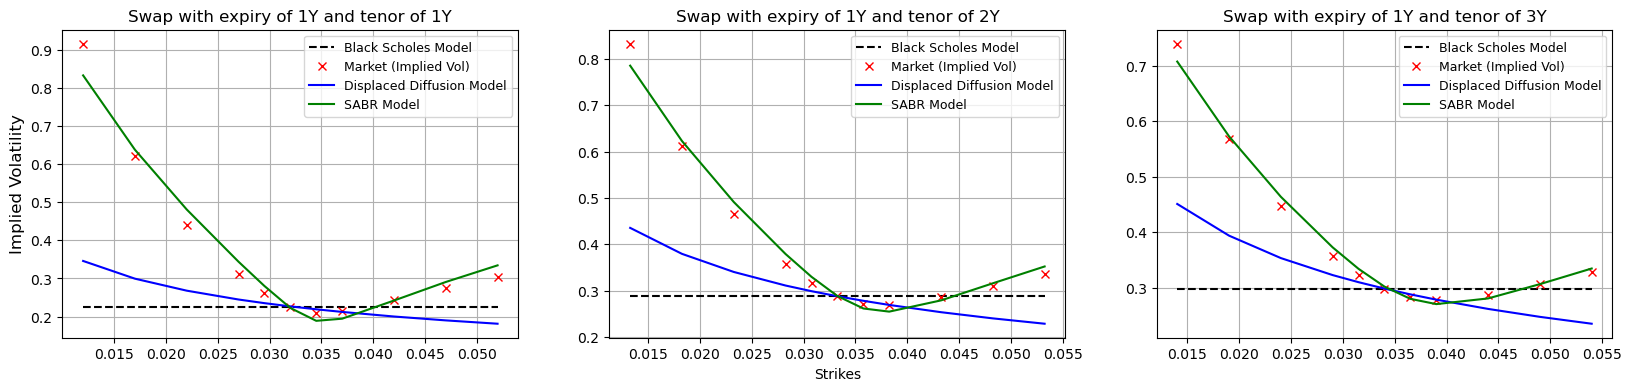

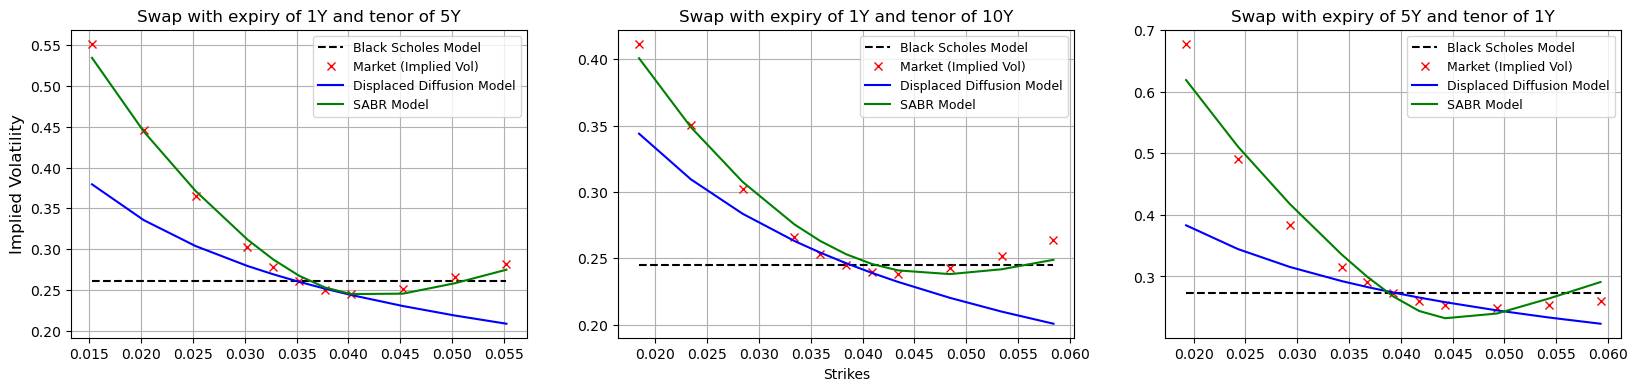

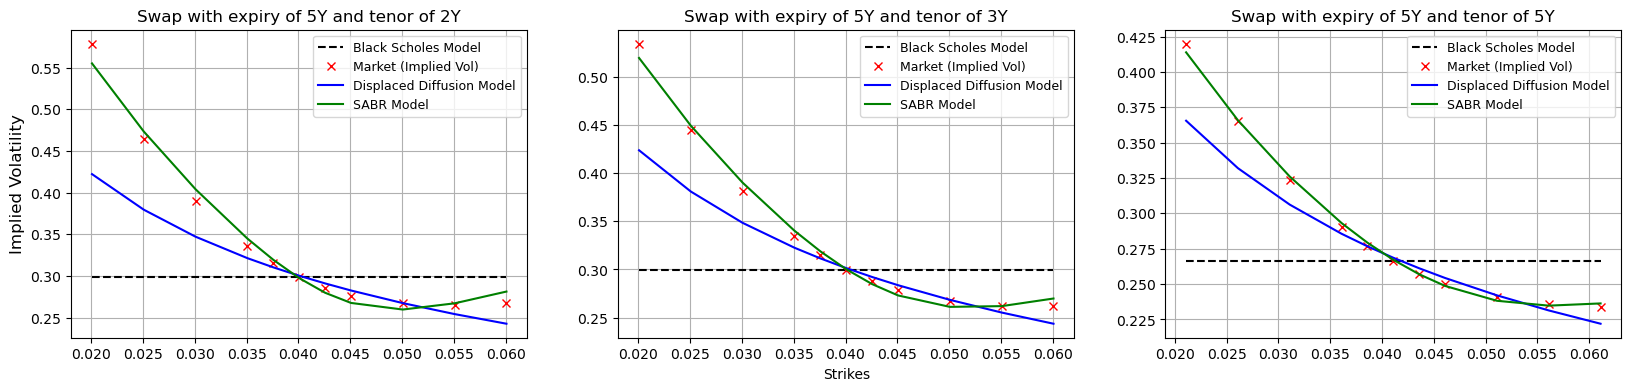

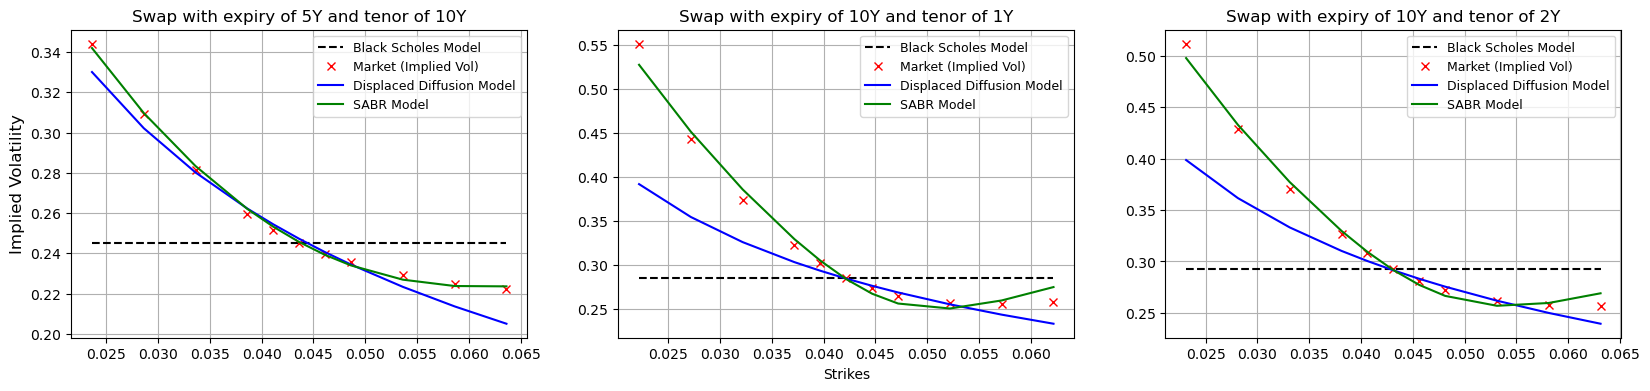

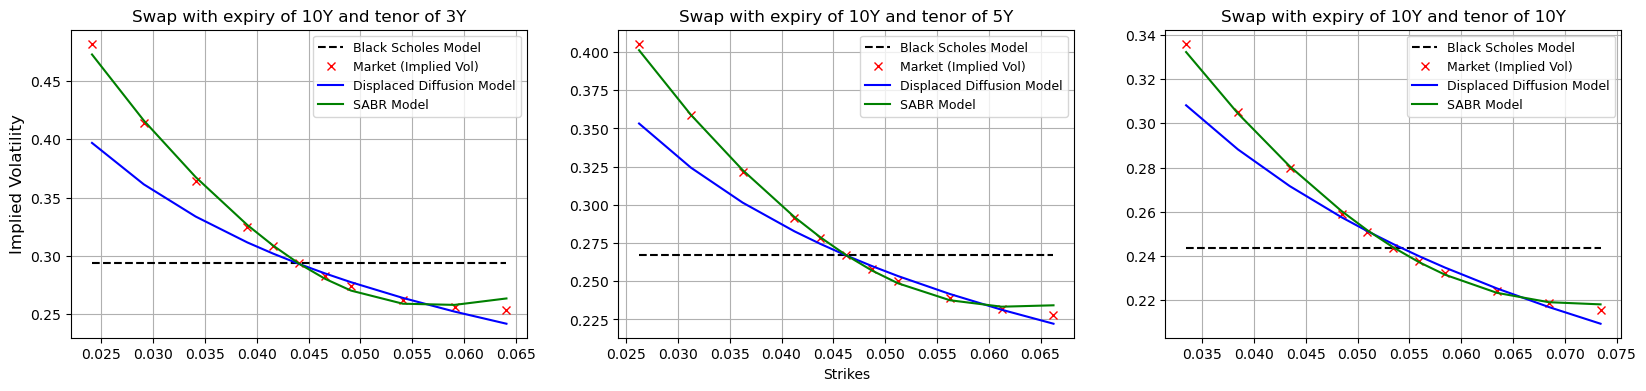

In [26]:
plotter()